In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
%cd ../..

/home/nassim


In [37]:
from src.qlearning import QLearningAgent
from src.utils import EpisodeStats
from envs.gridworld import GridworldEnv
import gym
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=80)

## Discretization visualization

In [38]:
env = gym.make('MountainCar-v0')

In [39]:

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot discretization as a grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)

    if low is None or high is None:
        x, y = grid[0], grid[1]
        low = [x[0], y[0]]
        high = [x[-1], y[-1]]
    else:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T)) 
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 
    x = discretized_samples[:, 0]
    y = discretized_samples[:, 1]

    gx = grid_centers[0, x] # pick grid centre for each x
    gy = grid_centers[1, y] # pick grid centre for each y
    locs = np.stack([gx, gy], axis=1)

    ax.plot(samples[:, 0], samples[:, 1], 'o', label='Original')
    ax.plot(locs[:, 0], locs[:, 1], 's', label='Discretized')
    ax.legend()
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))

In [40]:
def create_discretization_grid(low, high, bins=[10]):
    if len(bins) == 1:
        bins = np.repeat(bins, len(low))

    assert len(low) == len(high) == len(bins)

    grid = [np.linspace(low[i], high[i], bins[i], endpoint=False)[1:] for i, _ in enumerate(low)]
    return np.array(grid)

def get_discrete_state(state, window_size, env):
    discrete_state = (state - env.observation_space.low)/window_size
    return tuple(discrete_state.astype(np.int))

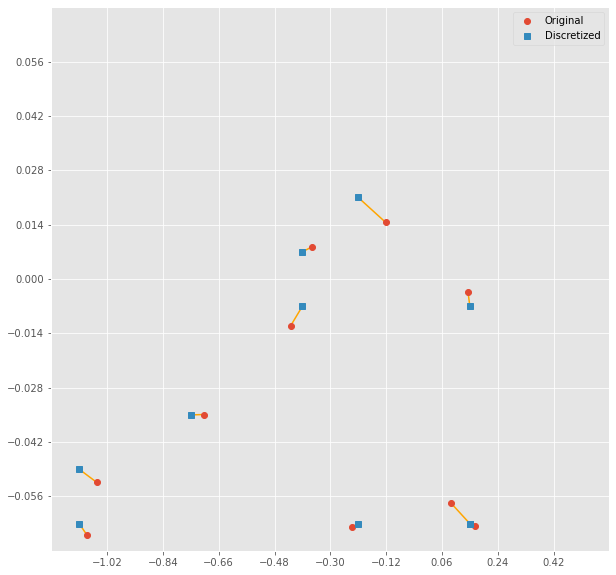

In [41]:
# Discretization parameters
state_size = (10, 10)
window_size = (env.observation_space.high - env.observation_space.low)/state_size

state_grid = create_discretization_grid(env.observation_space.low, env.observation_space.high)
samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_samples = np.array([get_discrete_state(sample, window_size, env) for sample in samples])

visualize_samples(samples, discretized_samples, state_grid, env.observation_space.low, env.observation_space.high)

## QLearning MountainCar

In [50]:
env = gym.make('MountainCar-v0')

state_size = (10, 10)
window_size = (env.observation_space.high - env.observation_space.low)/state_size
num_episodes = 5000
max_step = 200
env._max_episode_steps = max_step

params = {
    "gamma": 0.95,
    "alpha": 1,
    "min_alpha": 0.005,
    "epsilon": 1.0,
    "min_epsilon": 0.01
}

params["epsilon_decay_rate"] = (params["epsilon"] - params["min_epsilon"])/(num_episodes//2)
params["alpha_decay_rate"] = (params["alpha"] - params["min_alpha"])/(num_episodes//2)


In [53]:
stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=None)

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **params)

for episode in range(num_episodes):
    done = False
    success = False
    step = 0

    start = time.time()
    obs = env.reset()
    state = get_discrete_state(obs, window_size, env)

    while not done:
        action = q_agent.policy(state)
        next_obs, reward, done, _ = env.step(action)
        next_state = get_discrete_state(next_obs, window_size, env)

        if next_obs[0] >= env.goal_position:
            q_agent.Q[next_state + (action,)] = 0
            success = True
        else:
            q_agent.update(state, next_state, action, reward)
        state = next_state

        step+=1
        stats.episode_rewards[episode] += reward
        stats.episode_lengths[episode] = step 
    
    q_agent.decay_epsilon(episode)
    q_agent.decay_alpha(episode)

    if episode % 100 == 0:
        print("Episode {}/{}, Reward {}, Total steps {}, Epsilon: {:.2f}, Alpha: {:.2f}, Time {:.3f}".format(episode, num_episodes, stats.episode_rewards[episode], stats.episode_lengths[episode], q_agent.epsilon, q_agent.alpha, time.time()-start))

Episode 0/5000, Reward -200.0, Total steps 200.0, Epsilon: 1.00, Alpha: 1.00, Time 0.043
Episode 100/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.96, Alpha: 0.96, Time 0.020
Episode 200/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.92, Alpha: 0.92, Time 0.018
Episode 300/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.88, Alpha: 0.88, Time 0.022
Episode 400/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.84, Alpha: 0.84, Time 0.023
Episode 500/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.80, Alpha: 0.80, Time 0.022
Episode 600/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.76, Alpha: 0.76, Time 0.024
Episode 700/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.72, Alpha: 0.72, Time 0.024
Episode 800/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.68, Alpha: 0.68, Time 0.048
Episode 900/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.64, Alpha: 0.64, Time 0.030
Episode 1000/5000, Reward -200.0, Total steps 200.0, Epsilon: 0.60, Alpha: 0.60, Time 0.023


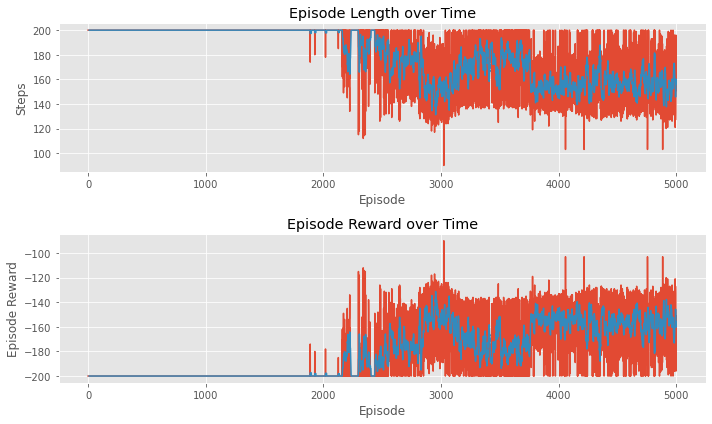

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(stats.episode_lengths)
rm = pd.Series(stats.episode_lengths).rolling(10).mean()
ax1.plot(rm)
ax1.set_xlabel("Episode")
ax1.set_ylabel("Steps")
ax1.set_title("Episode Length over Time")

ax2.plot(stats.episode_rewards)
rm = pd.Series(stats.episode_rewards).rolling(10).mean()
ax2.plot(rm)
ax2.set_xlabel("Episode")
ax2.set_ylabel("Episode Reward")
ax2.set_title("Episode Reward over Time")
fig.tight_layout()

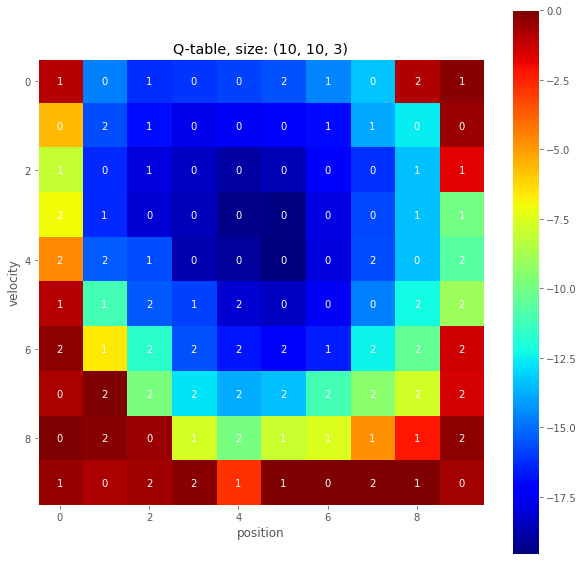

In [55]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet')
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(q_agent.Q)